<!--<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>-->

#### Applied AI Internal Demo Project
## t-SNE Demo (High Dimensional Data Viz)

Demo of high dimensional data visualisation with t-Distributed Stochastic Neighbor Embedding (aka t-SNE, more detail at https://lvdmaaten.github.io/tsne/) using the [Urban Land Cover Classification](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover) dataset from the UCI Machine Learning Repository.

The motivation is to:
1. find and prepare a suitable high-dimensional dataset
2. demonstrate why the raw data can be hard to visually interpret
3. run t-SNE to reduce the dataset to 2 dimensions for plotting and interpretation


Note: there are _**Observations**_ and _**Notes**_ throughout the Notebook, please read them.




# 01_EndToEnd_DataViz


+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)


+ [Data Description](#Data-Description)
    + [View class group sizes](#View-class-group-sizes)
    + [View distributions of feature values](#View-distributions-of-feature-values)


+ [Feature Reduction](#Feature-Reduction)
    + [Check for degeneracy and compressability (scipy svd method)](#Check-for-degeneracy-and-compressability-[scipy-svd-method])
    + [Feature Reduction (scikit-learn TruncatedSVD method)](#Feature-Reduction-[scikit-learn-TruncatedSVD-method])

    
+ [Basic Visualisation of Reduced Features](#Basic-Visualisation-of-Reduced-Features)
    + [Pairs Plots](#Pairs-Plots)
    + [3D Scatterplot](#3D-Scatterplot)
    
    
+ [t-SNE Visualisation](#t-SNE-Visualisation)
    + [Observe scaling on basic t-SNE](#Observe-scaling-on-basic-t-SNE)
    + [Calculate t-SNE representation](#Calculate-t-SNE-representation)
    + [View t-SNE representation with class labels](#View-t-SNE-representation-with-class-labels)
    
    
+ [In Review](#In-Review)


---

---

# Setup

Firstly we'll setup the Notebook, importing packages and defining local functions

In [9]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [10]:
from collections import OrderedDict
from time import time
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10, 6
np.random.seed(0)

In [11]:
cnx = sqlite3.connect('data/land_cover.db')

## Local Functions

In [12]:
def plot_3d_scatter(A, elevation=30, azimuth=120):
    """ Create 3D scatterplot """
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['class'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

## Load Data

### Download and pre-prepare the files 

Two files are available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00295/Urban%20land%20cover.zip) as a presplit training & test dataset. We'll identify where they came from using a new feature `orig_set`, and join them back together for this demo.

In [14]:
dforigtrain = pd.read_csv('data/training.csv')
dforigtrain.rename(columns=lambda x: '_'.join([x.strip() for x in x.lower().split()]), inplace=True)
dforigtrain['orig_set'] = 'train'
print(dforigtrain.shape)
dforigtrain.head()

(168, 149)


,class,brdindx,area,round,bright,compact,shpindx,mean_g,mean_r,mean_nir,...,lw_140,glcm1_140,rect_140,glcm2_140,dens_140,assym_140,ndvi_140,bordlngth_140,glcm3_140,orig_set
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36,train
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14,train
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04,train
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38,train
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38,train


In [15]:
dforigtest = pd.read_csv('data/testing.csv')
dforigtest.rename(columns=lambda x: '_'.join([x.strip() for x in x.lower().split()]), inplace=True)
dforigtest['orig_set'] = 'test'
print(dforigtest.shape)
dforigtest.head()

(507, 149)


,class,brdindx,area,round,bright,compact,shpindx,mean_g,mean_r,mean_nir,...,lw_140,glcm1_140,rect_140,glcm2_140,dens_140,assym_140,ndvi_140,bordlngth_140,glcm3_140,orig_set
0,concrete,1.32,131,0.81,222.74,1.66,2.18,192.94,235.11,240.15,...,5.04,0.80,0.58,8.56,0.82,0.98,-0.10,1512,1287.52,test
1,shadow,1.59,864,0.94,47.56,1.41,1.87,36.82,48.78,57.09,...,3.70,0.52,0.96,7.01,1.69,0.86,-0.14,196,2659.74,test
2,shadow,1.41,409,1.00,51.38,1.37,1.53,41.72,51.96,60.48,...,3.09,0.90,0.63,8.32,1.38,0.84,0.10,1198,720.38,test
3,tree,2.58,187,1.91,70.08,3.41,3.11,93.13,55.20,61.92,...,6.33,0.89,0.70,8.56,1.10,0.96,0.20,524,891.36,test
4,asphalt,2.60,116,2.05,89.57,3.06,3.02,73.17,94.89,100.64,...,1.01,0.83,0.75,8.62,2.08,0.08,-0.10,496,1194.76,test


#### Concatenate back together
(and separate out the `orig_set` identifier feature - we may use it later)

In [16]:
dfraw = pd.concat((dforigtrain,dforigtest), axis=0)
dforigset = dfraw['orig_set']
print(dforigset.shape)

df = dfraw[[c for c in dfraw.columns.values.tolist() if c != 'orig_set']]
print(df.shape)

(675,)
(675, 148)


##### Observe:
+ We have 675 instances for visualisation, with 147 + 1 features. Quite a wide dataset and likely to prove tricky to visualise.

#### Write to DB to allow easier loading later

In [17]:
df.to_sql('df_clean',cnx,if_exists='replace', index=None)

---

---

# Data Description

Our data is the [Urban Land Cover Classification](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover) dataset from the UCI Machine Learning Repository. 

+ This is a set of 675 pixels taken from aerial imagery of urban landscapes, each with a classification of the land type.

+ Each pixel is described by 147 features including area covered and the light intensity recieved in several wavelengths by the camera and postprocessed by imaging software. 

+ The 147 features are actually 7 sets of the following 21 'base' features, repeated at different physical scales, ranging from small area to coarse scale (i.e. feat_40, feat_60, ...feat_140). This is to help differentiate structures on the ground of different sizes e.g. trees vs buildings vs cars etc.


    BrdIndx: Border Index (shape variable) 
    Area: Area in m2 (size variable) 
    Round: Roundness (shape variable) 
    Bright: Brightness (spectral variable) 
    Compact: Compactness (shape variable) 
    ShpIndx: Shape Index (shape variable) 
    Mean_G: Green (spectral variable) 
    Mean_R: Red (spectral variable) 
    Mean_NIR: Near Infrared (spectral variable) 
    SD_G: Standard deviation of Green (texture variable) 
    SD_R: Standard deviation of Red (texture variable) 
    SD_NIR: Standard deviation of Near Infrared (texture variable) 
    LW: Length/Width (shape variable) 
    GLCM1: Gray-Level Co-occurrence Matrix [i forget which type of GLCM metric this one is] (texture variable) 
    Rect: Rectangularity (shape variable) 
    GLCM2: Another Gray-Level Co-occurrence Matrix attribute (texture variable) 
    Dens: Density (shape variable) 
    Assym: Assymetry (shape variable) 
    NDVI: Normalized Difference Vegetation Index (spectral variable) 
    BordLngth: Border Length (shape variable) 
    GLCM3: Another Gray-Level Co-occurrence Matrix attribute (texture variable) 
    
    
> _**Note:**_ All features are numeric but are on different scales
    
    

In [18]:
df = pd.read_sql('select * from df_clean', cnx)

## View class group sizes

How many pixels belong to each land class type?

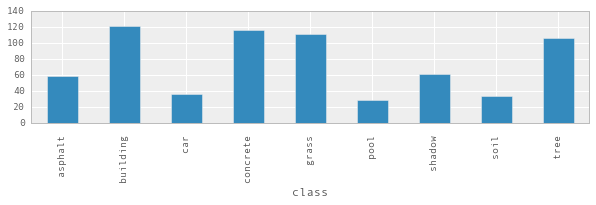

In [19]:
ax = df.groupby('class').size().plot(kind='bar', figsize=(10,2))

##### **Observe:**
+ The classes are moderately well balanced, with buildings, concrete, grass and tree taking the most pixels
+ Any useful visualisation will have to be good at separating and showing the smaller classes of car, pool and soil.

## View distributions of feature values

We'll create a simple facetted boxplot visualisation of the distributions of the 21 basic feature values per land classification, showing the values at different scales.

Essentially, this is a summarised view of the land classifications. What we really want to see is how pixels from the different land classifications cluster together.

In [20]:
grps = ['40','60','80','100','120','140']
basic = ['brdindx','area','round','bright','compact','shpindx'
         ,'mean_g','mean_r','mean_nir','sd_g','sd_r','sd_nir'
         ,'lw','glcm1','rect','glcm2','dens','assym','ndvi','bordlngth','glcm3']

idxdict = OrderedDict()
for b in basic:
    idxdict[b] = [b] + ['{}_{}'.format(b,g) for g in grps]

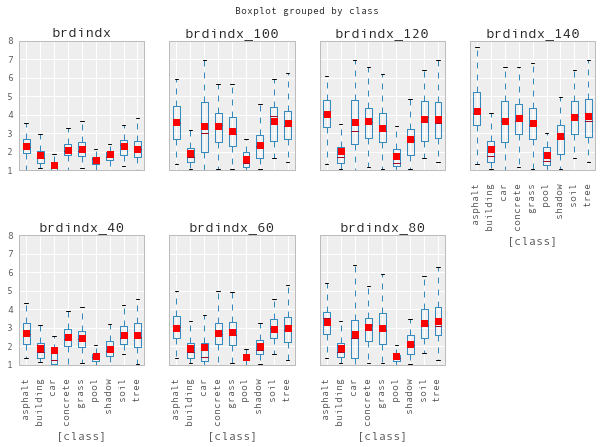

In [21]:
def plot_raw_vals(df, k):
    v = idxdict[k]
    dfg = pd.concat((df[['class']],df[v]), axis=1)
    ax = dfg.boxplot(by='class', layout=(2,4), figsize=(10,6)
                    ,showfliers=False, showmeans=True, rot=90)

interactive(plot_raw_vals, df=fixed(df), k=basic)

##### Observe:
+ We can select different sets of features using the dropdown and see differences in the land classifications
+ However, it's really hard to visualise the differences between land classifications across all the 147 features!
+ We can state that, for example, grass and tree are obviously different from the other classes by using the `ndvi` features (NDVI is designed to help spot vegetation), but it's hard to state how different, and read the differences arcross all the other basic features.

> Clearly we can do better than this for visualization.

---

---

# Feature Reduction

We want to make the problem more managable, by removing dimensionality where possible, whilst preserving as much information as possible

### Standardize

As a preprocessing step, standardize the feature values so they are all mean-centered and have unit variance - this makes comparisons simpler and allows next steps for SVD.

_**Note:**_ Normally would also detect and view outliers as part of the discovery process, but in this case we can be more brief since the data is well-understood and clean.

In [22]:
scaler = StandardScaler().fit(df.iloc[:,1:])
dfs = pd.DataFrame(scaler.transform(df.iloc[:,1:]), index=df.index, columns=df.columns[1:])

## Check for degeneracy and compressability (`scipy` `svd` method)

In an ideal dataset, all features provide new information and don't contain perfect mutual correlations aka degeneracy. 

For example, if we had two features in a dataset of human body measurements `height` and `weight`, we anticipate that whilst there will be a positive corrolation, the `height` feature cannot perfectly describe the `weight` feature. In contrast, if we had a dataset of measurements of square tabletops - `length` and `width` - we know that the `length` feature would perfectly describe the `width` feature, i.e. the features would be degenerate.

[Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) is a matrix factorization commonly used in signal processing and data compression. The m x n matrix $\mathbf{M}$ can be represented as a combination of rotation and scaling matrices $\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$.

Here we will use the `svd` function in the `scipy` package to calculate the SVD and observe the singular values $\boldsymbol{\Sigma}$; if any are very close to zero then we have some degeneracy in the full dataset which we should definitely try to remove or avoid.

In [23]:
u, s, vt = svd(dfs)

#### Are any eigenvalues NaN or really small?

0 SVs are NaN
0 SVs less than 1e-12


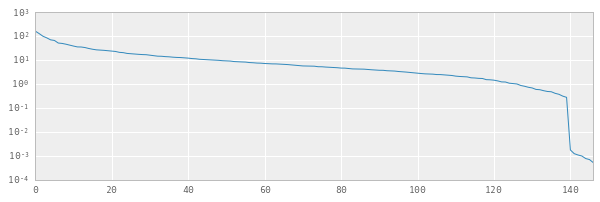

In [24]:
ax = pd.Series(s).plot(figsize=(10,3), logy=True)
print('{} SVs are NaN'.format(np.isnan(s).sum()))
print('{} SVs less than 1e-12'.format(len(s[s < 1e-12])))

##### Observe:
+ We seem to have no perfect degeneracy which is good: the dataset is well-behaved

#### View explained variance

Variance preserved by first 100 components == 99.89%
Variance preserved by first 5 components == 71.71%


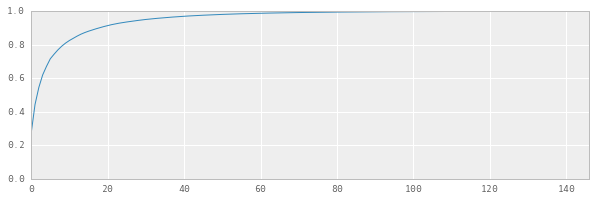

In [25]:
idx = ~np.isnan(s)
xtrans = np.dot(u[:,idx], np.diag(s[idx]))
expvar = np.var(xtrans, axis=0)
fullvar = np.var(dfs, axis=0)
expvarrat = expvar/fullvar.sum()
ax = pd.Series(expvarrat.cumsum()).plot(kind='line', figsize=(10,3)).set_ylim([0,1])
print('Variance preserved by first 100 components == {:.2%}'.format(expvarrat.cumsum()[100]))
print('Variance preserved by first 5 components == {:.2%}'.format(expvarrat.cumsum()[5]))

##### Observe:

+ Surprisingly, it seems like we can compress the 147 original features into 100 components (eigenvectors) without only 0.11% loss of variance! There's clearly some near-degeneracy in the data.
+ If we get really extreme, we could consider representing the dataset using only the first 5 components and still maintain ~72% of the variance.

> We'll use SVD to reduce the dataset slightly - removing near-degeneracy, trying to preserve variance and thus replicating what we might do in the real-world prior to running machine learning algorithms such as CART and clustering etc.

## Feature Reduction (`scikit-learn` `TruncatedSVD` method)

Secondly, here we'll use the `TruncatedSVD` method in the `scikit-learn` package (Truncated-SVD is a [quicker calculation](https://en.wikipedia.org/wiki/Singular_value_decomposition#Reduced_SVDs), and using `scikit-learn` is more convenient and consistent with our usage elsewhere) to transform the full dataset into a representation using the top 50 components, thus preserving variance in the data but using fewer dimensions to do so. This has a similar effect to [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) where we represent the original data using an orthogonal set of axes rotated and aligned to the variance in the dataset.

_**Note:**_ there's nothing special about using the top 50 components, it's just a nice round number which preserves a lot of variance and is still too large to easily visualise, necessitaing our using t-SNE.

Variance preserved by first 50 components == 98.12%


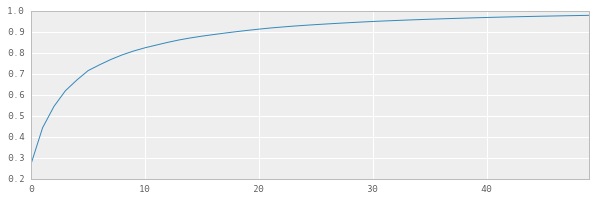

In [26]:
ncomps = 50
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(dfs)
Y = svd.fit_transform(dfs) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first 50 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

##### Observe:
+ We can preserve 98.12% variance by using just 50 components rather than the full 147 original features. This is a really useful compression, removing degeneracy and allowing all downstream analyses / algorithms to be faster whilst retaining useful information.

> For convenience, we'll create a dataframe specifically for these top 50 components.

In [27]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=df.index)
print(dfsvd.shape)
dfsvd.head()

(675, 50)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49
0,7.791615,-5.665540,-5.142433,6.568801,0.475720,3.587330,6.566216,1.328912,-3.042453,-1.700795,...,0.415169,-0.794654,-0.223146,0.489286,0.213785,-0.232489,-0.911058,-0.641614,0.403240,-0.758649
1,2.402245,5.520586,-1.305692,0.568924,-1.699060,1.912092,-0.956357,1.180367,1.274169,0.002813,...,0.160471,-0.413665,0.310245,0.327412,-0.299997,0.209969,-0.190505,-0.464062,-0.266796,-0.178476
2,6.655337,-1.089973,-1.486441,-0.761643,1.091498,0.549244,-1.511058,-1.215297,1.181897,-1.607650,...,-0.342962,-0.027957,0.047161,0.730313,-0.153858,0.048440,0.811587,-0.153610,-0.171254,-0.116115
3,6.786879,4.643247,0.469147,-0.637604,0.877795,2.365046,-1.154191,0.027911,1.693199,-1.822488,...,0.295681,0.038817,-0.783326,-0.149290,-0.411174,0.142764,-0.027371,-0.540669,-0.057306,-0.312100
4,1.416315,13.627604,5.196395,5.980829,10.790677,-3.430901,-4.159976,3.382595,-0.675996,6.953366,...,-0.074750,0.987806,0.767721,1.241851,1.122658,0.130145,0.841760,-1.236563,-0.979944,-0.976531


#### Write to DB

In [28]:
dfsvd.to_sql('df_svd',cnx,if_exists='replace', index=None)

---

---

# Basic Visualisation of Reduced Features

Now that we have a compressed dataset, represented by the top 50 components of an SVD, lets attempt to visualise the data

In [29]:
dfsvd = pd.read_sql('select * from df_svd', cnx)
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

df = pd.read_sql('select * from df_clean', cnx)

## Pairs Plots

Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (land usage type).

Here we view pair-plots for the first 5 components:

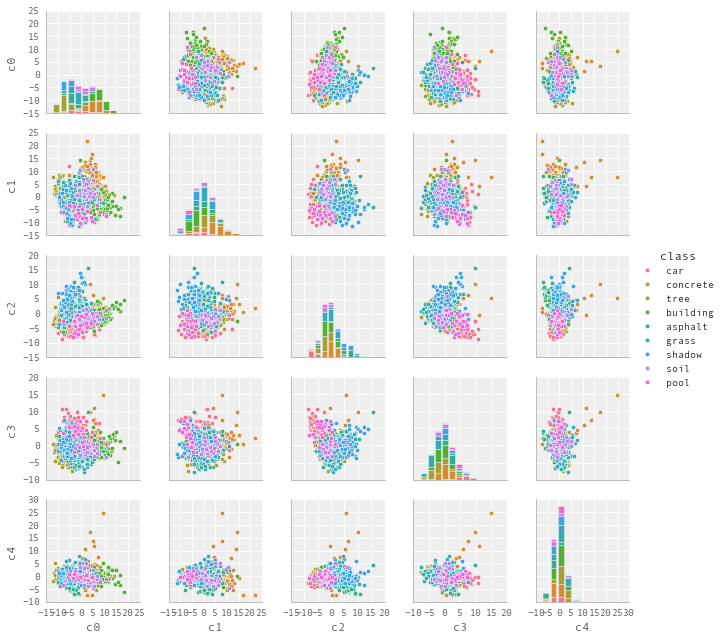

In [30]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['class'] = df['class']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='class', size=1.8)

##### Observe:

+ We can clearly see that datapoints from the same land usage classes tend to cluster together
+ It's possible to see distinct classes on different sides of the plots, e.g.
    + `building` is very different to `tree` along the `c0` component, and
    + `concrete` is far from `shadow` along the `c1` component
+ However, this pairs-plot suffers several issues for visualisation:
    + It shows only the first 5 components of the available 50, meaning we only see 72% of the full variance
    + If we try to show more components, the overall plot will get very large indeed: up to 50 x 50 plots
    + It's hard to get a full appreciation of the differences and similarities between datapoints across all the components, requiring that the reader hold comparisons in their head while viewing
    + Classes with lower counts e.g. `car` and `pool` are really hard to see


## 3D Scatterplot

As an alternative to the pairs-plots, we could view a 3D scatterplot, which at least lets us see more dimensions at once and possibly get an interactive feel for the data

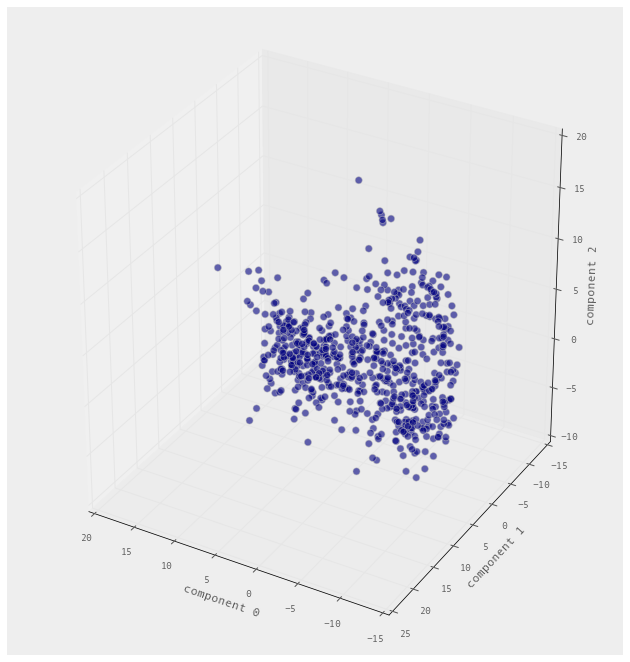

In [31]:
dfsvd['class'] = df['class']
interactive(plot_3d_scatter, A=fixed(dfsvd), elevation=30, azimuth=120)

##### Observe:
+ The iPython Notebook interactive package lets us create an interactive plot with controls for elevation and azimuth
+ We can use these controls to interactively change the view of the top 3 components and investigate their relations. This certainly appears to be more informative than pairs-plots.
+ However, we still suffer from the same major limitations of the pairs-plots, namely that we lose a lot of the variance and have to hold a lot in our heads when viewing.

> We clearly need a better way to visualise the 675 datapoints and their 50 dimensions


---

---

# t-SNE Visualisation

Finally we're ready for the meat of this Notebook: t-SNE Manifold Learning.

t-SNE is a technique for probabilistic dimensionality reduction, developed within the last 10 years and with wider reception in the last 2-3 years, lots of detail at https://lvdmaaten.github.io/tsne/.

We will use the basic implementation available in `scikit-learn` which has O(n^2) complexity. Ordinarily this prohibits use on real-world datasets (and we would instead use the Barnes-Hut implementation O(n*log(n))), but for out 675 datapoints it's no problem. 

> We will, however, quickly demonstrate the scaling issue:

## Observe scaling on basic t-SNE

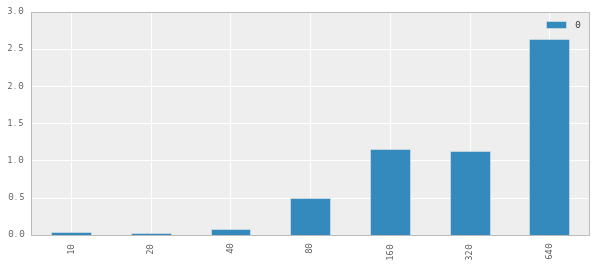

In [32]:
rowsubset = [10,20,40,80,160,320,640]
tsne = TSNE(n_components=2, random_state=0)
runs = np.empty((len(rowsubset),1))

for i, rows in enumerate(rowsubset):
    t0 = time()
    Z = tsne.fit_transform(dfsvd.iloc[:rows,:][svdcols])
    runs[i] = time() - t0

ax = pd.DataFrame(runs, index=rowsubset).plot(kind='bar', logy=False, figsize=(10,4))

##### Observe
+ As we anitcipate, we see that basic t-SNE scales badly O(n^2)
+ However, this dataset is small and calculation is quick on my laptop, so I won't use the faster Barnes-Hut implementation O(n*log(n))

## Calculate t-SNE representation

Firstly we'll calcualte the t-SNE 2D representation for our 50D dataset, and view the results without coloring the classes.

In [33]:
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

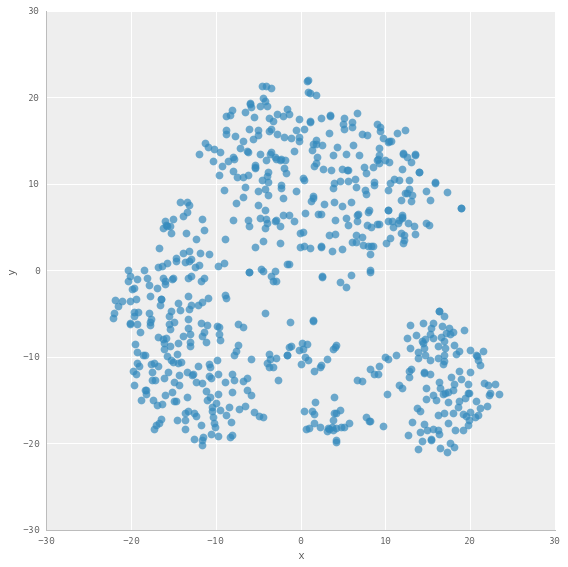

In [34]:
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

##### Observe:
+ This is promising... we've reduced our top 50 SVD components to 2 dimensions and we can clearly see clusters of datapoints.
+ When doing unsupervised learning (without class labels) we might expect to get this far and then backtrack to run clustering algorithms in the 50 dimensional space.


> Now let's view the t-SNE representation with land classification class labels...

## View t-SNE representation with class labels

In [35]:
dftsne['class'] = df['class']

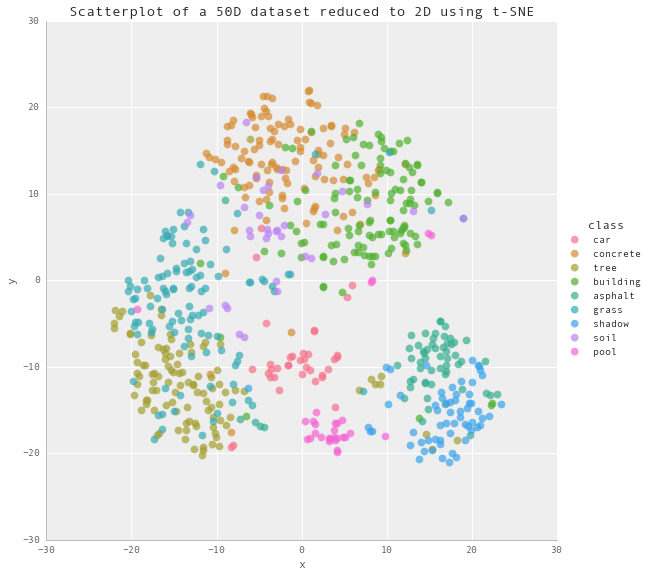

In [36]:
g = sns.lmplot('x', 'y', dftsne, hue='class', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 50D dataset reduced to 2D using t-SNE')

##### Observe
+ This is really interesting! With class labels added we can clearly see the clustering of pixels of the various land-type classes, all at once on a single 2D scatterplot.

+ Again we see e.g. `building` as a very distinct cluster from `tree` but now also as distinct from `asphalt`, `shadow`, `grass`, `car` and `pool`

+ Now we can start to see similarities in classes, e.g.
    + `shadow` and `asphalt` - presumably they appear dark on the images
    + `car` and `pool` - presumably they have high relfectance and have a small area
    + `tree` and `grass` - presumably as vegetation they have similar red and infra-red absorption.
    
> The great thing about the t-SNE representation is that is preserves local structure present at high dimensions, meaning that neighboring points also appear close in the low dimensional representation. Clusters of similar classes are obvious and intuitive.

---

---

# In Review

We have sourced and prepared a small but high-dimensional dataset and demonstrated:
+ The difficulty of visualising the raw data and distributions
+ The benefits of using feature reduction to detect and remove degeneracy and reduce redundancy
+ The difficulty of visualising even the prepared data, because it simply has too many dimensions for straightforward 2D and 3D plotting
+ The benefit of using t-SNE to create a low dimensional representation of the high dimensional data, and how the local structure is preserved such that class clusters can be easily seen.

---

<!--<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>-->
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>